# Testing binarsity on the adult dataset

In this notebook I test a draft implementation of the `BinarsityClassifier` on the Adult dataset (https://archive.ics.uci.edu/ml/datasets/Adult).

In [1]:
%pylab inline

NUM_COLORS = 5

cm = get_cmap('gist_rainbow')
color = []
for i in range(NUM_COLORS):
    color.append(cm(1.*i/NUM_COLORS))

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

from collections import defaultdict

from sklearn import cross_validation, datasets, pipeline, svm
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

from prox_tv.binarizer import LabelBinarizer, BinarsityClassifier
from prox_tv.utils import LogisticInspector

### Load dataset

In [3]:
df = pd.read_csv('datasets/adult/adult.data')

In [4]:
X, y = df.ix[:, :-1], df[" label"]

In [5]:
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(X.T.to_dict().values())

mask = [True if name.endswith('continuous') else False for name in vectorizer.get_feature_names()]
binarizer = LabelBinarizer(n_cuts=10, mask=mask)
X = binarizer.fit_transform(X)

X = StandardScaler().fit_transform(X)  # Should fit this only on train set probably.

In [6]:
y = 2 * (y.values == y.values[0]) - 1

### Look at the parameters

Training by default is done with a very basic implementation of the ISTA algorithm. Blocksizes are input manually for this dataset. The blocksizes `[10, 10, 17, 10, 88]` perform binarsity penalization on the blocks of size 10 in this case.

In [7]:
blocksizes = [10, 10, 17, 10, 88]
tv_mask = binarizer.tv_mask
max_iter = 1000

In [8]:
clf = BinarsityClassifier(l1=0.01, l2=0.01, l_tv=1e-2,
                          blocksizes=blocksizes, mask=tv_mask,
                          max_iter=max_iter, inspector=LogisticInspector(X, y))

In [9]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=.4)
w = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8512859884836852

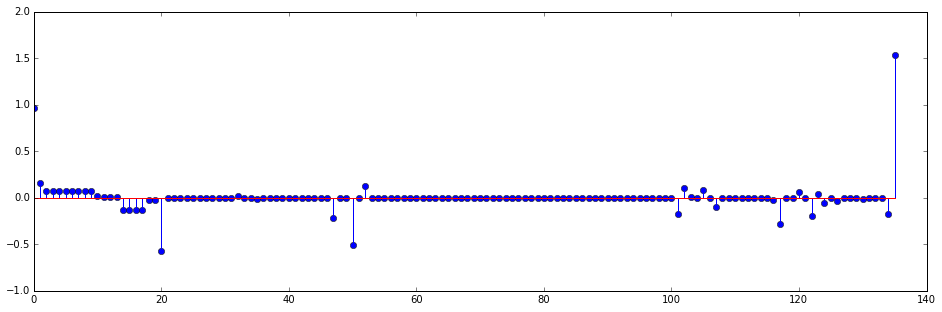

In [10]:
plt.figure(figsize=(16, 5))
plt.stem(w)
plt.show()

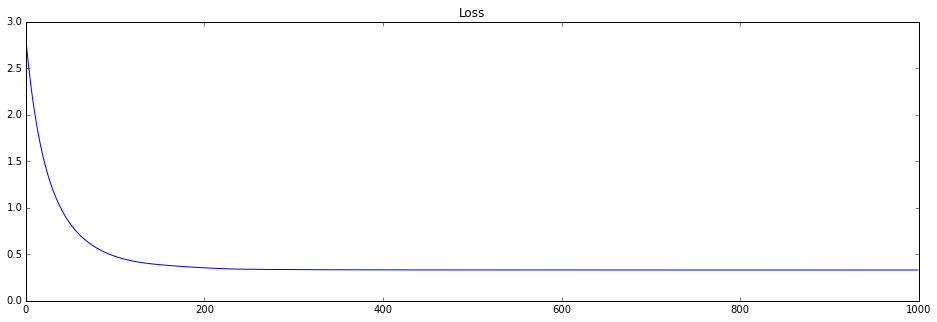

In [11]:
plt.figure(figsize=(16, 5))
plt.plot(clf.inspector.objectives)
plt.title("Loss")
plt.show()

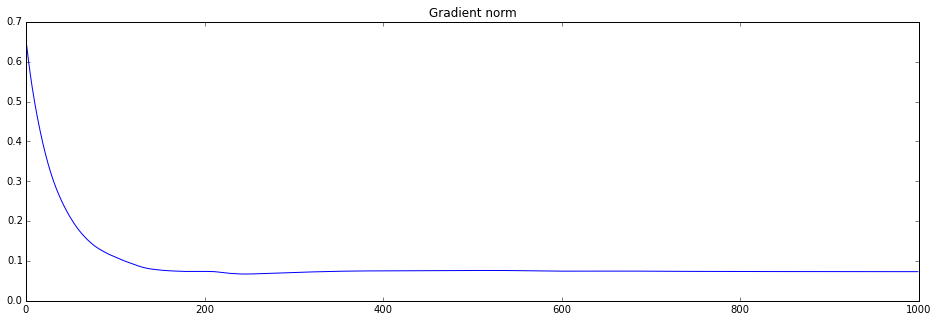

In [12]:
plt.figure(figsize=(16, 5))
plt.plot(clf.inspector.grd_norm)
plt.title("Gradient norm")
plt.show()

It seems the stepsize prevents the gradient form converging to a smaller value than `0.1`. Using a smaller lipschitz constant or an adaptive stepsize should perform better.

### Cross-validate

We cross-validate on the parameter `C` for the svm and `l_tv` for `BinarsityClassifier`. Note that the smaller `C` is in the `svm`, the stronger the reglarization (it is the opposite for `l_tv`).

In [13]:
classifier_names = ['svm', 'blog']
scores = defaultdict(list)
scores_std = defaultdict(list)

C_s = np.logspace(-10, 0, 10)

for classifier_name in classifier_names:
    for C in C_s:
        if classifier_name == 'svm':
            clf = svm.LinearSVC(C=C)
        elif classifier_name == 'blog':
            clf = BinarsityClassifier(l_tv=C, blocksizes=blocksizes, mask=tv_mask, max_iter=max_iter)
        this_scores = cross_validation.cross_val_score(clf, X, y, n_jobs=1)
        scores[classifier_name].append(np.mean(this_scores))
        scores_std[classifier_name].append(np.std(this_scores))

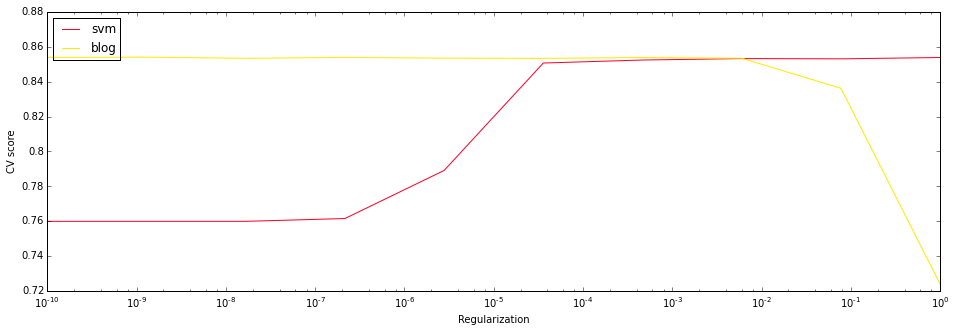

In [14]:
plt.figure(1, figsize=(16, 5))

for i, clf_name in enumerate(classifier_names):
    plt.semilogx(C_s, scores[clf_name], color=color[i])
#     plt.semilogx(C_s, np.array(scores[clf_name]) + np.array(scores_std[clf_name]), '--', color=color[i])
#     plt.semilogx(C_s, np.array(scores[clf_name]) - np.array(scores_std[clf_name]), '--', color=color[i])

locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.legend(['svm', 'blog','rlog'], loc=2)
plt.ylabel('CV score')
plt.xlabel('Regularization')
plt.show()